## Analyis Spotify

### Loading Libraries 

In [3]:
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,  mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import issparse, hstack, csc_matrix, csr_matrix, isspmatrix
from scipy import sparse, linalg
from sklearn.model_selection import learning_curve, validation_curve
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp
from scipy.sparse.linalg import cg
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances
from category_encoders import LeaveOneOutEncoder

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

In [5]:
warnings.filterwarnings('ignore', category=FutureWarning)
def function_that_warns():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    function_that_warns()



### Brief Explanation Cleaning and Customised Codes

When conducting our exploratory analysis we have have found a few things that are important before conducting our analysis. There . In this stage of pre-processing we will be conducting the following actions:

1) Converting "explicit" from boolean logical to 1s and 0s,
2) Converting "duration_ms" from milliseconds to seconds and storing it as "duration_s",
3) Conducting a $\log(X + 1)$ transormation on variables such as "duration_s", "speechiness", "accousticness", "intrumentalness", and "liveness",
4) Standardization of variables,
5) Extracting the artists names by splitting on ";" and using hot one encoding,
6) Extracting the track genre by splitting on ',' and using hot one econding  
7) Conducting hot one encoding on any categorical variables that are included
8) Experimenting with different encoding for the categorical to compare performance.

Inorder to conduct these we will be relying on the custom pipeline generator from sklearn. So we will be creating different classes of the tranformations aformentioned so that we can make our tranformation process simpler cleaner.

 In this project we will be implementing Ridge Regression from scratch. The custom class called 'Ridge_Regression' uses the normal equation and the gardient descennt approach to learn from the training set and predict for the test set. It also inlucdes different plot to asses the performance of the algorithm such as the learning curve the residual plot and distribution

In [6]:
class DurationConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None) :
        X = X.copy()
        X["duration_ms"] = X["duration_ms"] / 1000
        X = X.rename(columns={"duration_ms": "duration_s"})
        return X
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            input_features = ['duration_s' if name == 'duration_ms' else name for name in input_features]
        return np.array(input_features if input_features is not None else [])

class ExplicitConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X['explicit'] = X['explicit'].astype(int)
        return X

    def get_feature_names_out(self, input_features=None):
        return np.array(input_features if input_features is not None else [])

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        for col in self.columns:
            X[col] = np.log1p(X[col])
            X = X.rename(columns={col: col + '_log'})
        return X

    def get_feature_names_out(self, input_features=None):
        transformed_cols = [(col + '_log' if col in self.columns else col) for col in (input_features if input_features is not None else [])]
        return np.array(transformed_cols)

class ArtistExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y = None):
        X = pd.DataFrame(X)
        artists = X.iloc[:, 0].str.split(';')
        self.mlb.fit(artists)
        return self

    def transform(self, X, y = None):
        X = pd.DataFrame(X)
        artists = X.iloc[:, 0].str.split(';')
        return self.mlb.transform(artists)

class GenreExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        genres = X.iloc[:, 1].str.split(',')
        self.mlb.fit(genres)
        return self

    def get_feature_names_out(self, input_features=None):
        transformed_cols = [(col + '_log' if col in self.columns else col) for col in (input_features if input_features is not None else [])]
        return np.array(transformed_cols)


class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        # Split the column into separate genres
        data = X[self.column].str.split(',')
        self.mlb.fit(data)
        return self

    def transform(self, X):
        # Transform the column
        data = X[self.column].str.split(',')
        encoded_data = self.mlb.transform(data)

        # Convert to DataFrame if needed
        encoded_df = pd.DataFrame(encoded_data, columns=self.mlb.classes_)

        # Make sure the indices match before concatenating
        encoded_df.index = X.index

        # Concatenate with the original DataFrame
        X = pd.concat([X, encoded_df], axis=1)

        # Drop the original column
        X = X.drop(self.column, axis=1)

        return X

class CustomStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        X_scaled = X.copy()
        X_scaled[self.columns] = self.scaler.transform(X[self.columns])
        return X_scaled

    def get_feature_names_out(self, input_features=None):
        return np.array(input_features if input_features is not None else [])



In [7]:
class Ridge_Regression():
    def __init__(self, learning_rate=0.01, iterations=100000, alpha=0.1, solver="closed"):
        self.lr = learning_rate
        self.it = iterations
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None
        self.weights = None
        self.solver = solver
        if self.solver not in ["closed", "gradient_descent"]:
            raise ValueError("Invalid solver. Choose 'gradient_descent' or 'closed' form")


    def get_params(self, deep=True):
        return {"learning_rate": self.lr, "iterations": self.it, "alpha": self.alpha, "solver": self.solver}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        if sp.issparse(X):
            return hstack((intercept, X))  # Add intercept to sparse matrix
        else:
            return np.c_[intercept, X]  # Add intercept to dense matrix

    def closed(self, X, y):
        X_with_intercept = self.add_intercept(X)
        XtX = X_with_intercept.T @ X_with_intercept
        Xty = X_with_intercept.T @ y
        if sp.issparse(X):  # If X is a sparse matrix
            I = np.eye(X_with_intercept.shape[1])  # Use dense identity matrix
            I[0, 0] = 0
            I = csc_matrix(I)  # Convert to sparse matrix
            regularizer = self.alpha * I
            XtX_plus_alphaI = XtX + regularizer
            self.weights, _ = cg(XtX_plus_alphaI, Xty)  # Use Conjugate Gradient method
        else:  # If X is a dense matrix
            I = np.identity(X_with_intercept.shape[1])  # Use dense identity matrix
            I[0][0] = 0
            self.weights = np.linalg.inv(XtX + self.alpha * I) @ Xty
        self.intercept_ = self.weights[0]
        self.coef_ = self.weights[1:]

    def predict(self, X):
        X_with_intercept = self.add_intercept(X)
        return X_with_intercept @ self.weights

    def score(self, X, y):
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u/v

    def gradient_descent(self, X, y):
        X_with_intercept = self.add_intercept(X)
        self.costs = []
        for epoch in range(self.it):
            regularization = self.alpha * np.append([0], self.weights[1:])
            dW = (X_with_intercept.T @ (X_with_intercept @ self.weights - y)) + regularization
            self.weights = self.weights - self.lr * dW
            self.intercept_ = self.weights[0]
            self.coef_ = self.weights[1:]

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1] + 1)  # Initialize weights
        if self.solver == "closed":
            self.closed(X, y)
        elif self.solver == "gradient_descent":
            self.gradient_descent(X, y)

    def ridge_coefficients(self, X, y):
        alphas = np.logspace(-1, 10, 200)
        coefs = []
        for a in alphas:
            self.alpha = a
            self.fit(X, y)
            coefs.append(self.coef_)
        return alphas, coefs

    def coefficient_error(self, X_train, y_train, X_val, y_val):
        alphas = np.logspace(-1, 10, 200)
        train_errors = []
        val_errors = []
        for a in alphas:
            self.alpha = a
            self.fit(X_train, y_train)
            y_train_pred = self.predict(X_train)
            y_val_pred = self.predict(X_val)
            train_error = mean_squared_error(y_train, y_train_pred)
            val_error = mean_squared_error(y_val, y_val_pred)
            train_errors.append(train_error)
            val_errors.append(val_error)

        return alphas, train_errors, val_errors

    def learning_curve(self, X, y, X_val, y_val, title):
        train_errors, val_errors = [], []
        for m in range(1, X.shape[0]):
            self.fit(X[:m], y[:m])
            y_train_predict = self.predict(X[:m])
            y_val_predict = self.predict(X_val)
            train_errors.append(mean_squared_error(y[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))

        # Convert errors to RMSE
        train_errors = np.sqrt(train_errors)
        val_errors = np.sqrt(val_errors)

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Plot the errors
        ax.plot(range(1, X.shape[0]), train_errors, '-', label='Training Set')
        ax.plot(range(1, X.shape[0]), val_errors, '-', label='Cross-validation Set')

        # Set labels and title
        ax.set_xlabel('Training set size', fontsize=14)
        ax.set_ylabel('RMSE', fontsize=14)
        ax.set_title(title)

        # Add a legend
        ax.legend(loc='best')

        return fig

    def plot_costs(self):
        plt.plot(self.costs)
        plt.xlabel('Iteration')
        plt.ylabel('Cost (Mean Squared Error)')
        plt.title('Cost Function During Gradient Descent')
        plt.show()

In [8]:
def plot_ridge_coefficients(alphas, coefs, feature_names, title_suffix):
    plt.figure(figsize=(15, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(feature_names)))
    for i, color in zip(range(len(feature_names)), colors):
        plt.semilogx(alphas, [coef[i] for coef in coefs], label=feature_names[i], color=color)
    plt.xlabel('α (Regularization Parameter)')
    plt.ylabel('Coefficients')
    plt.title('Ridge Coefficients as a Function of the Regularization Strength ' + title_suffix)
    plt.legend()
    plt.show()

def plot_coefficient_error(alphas, train_errors, val_errors, title_suffix):
    plt.figure(figsize=(10, 6))
    plt.semilogx(alphas, train_errors, label='Training error')
    plt.semilogx(alphas, val_errors, label='Validation error')
    plt.xlabel('α (Regularization Parameter)')
    plt.ylabel('MSE')
    plt.title('Coefficient Error as a Function of the Regularization Strength ' + title_suffix)
    plt.legend()
    plt.show()


In [9]:
def plot_ridge_and_error(alphas, coefs, train_errors, val_errors, feature_names, title_suffix):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot on the first subplot
    colors = cm.rainbow(np.linspace(0, 1, len(feature_names)))
    for i, color in zip(range(len(feature_names)), colors):
        axs[0].semilogx(alphas, [coef[i] for coef in coefs], label=feature_names[i], color=color)
    axs[0].set_xlabel('α (Regularization Parameter)', fontsize=14)
    axs[0].set_ylabel('Coefficients', fontsize=14)
    axs[0].set_title('Ridge Coefficients as a Function of the Regularization Strength ' + title_suffix, fontsize=10)
    axs[0].legend()

    # Plot on the second subplot
    axs[1].semilogx(alphas, train_errors, label='Training error')
    axs[1].semilogx(alphas, val_errors, label='Validation error')
    axs[1].set_xlabel('α (Regularization Parameter)', fontsize=14)
    axs[1].set_ylabel('MSE', fontsize=14)
    axs[1].set_title('Error as a Function of the Regularization Strength ' + title_suffix, fontsize=10)
    axs[1].legend()

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()


### Loading Spotify Dataset,  Initial Cleaning  and Splitting


In this stage we will be conducting the initial cleaning processed and since we already have conducted the data exploration, we will just be running the code that would enable us to get a clean data. Furthermore after the intial cleaning stage we will be randomly splitting our data to training set and testing set. Our split will consist of 75% of the data being allocated to the training set and the remaining for the testing set.

In [12]:
spotify = pd.read_csv("dataset.csv")

<ipython-input-12-e347ac1cebd2>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  spotify = pd.read_csv("dataset.csv")


In [13]:
spotify_clean = spotify.dropna()
spotify_grouped_track_id = spotify_clean.groupby('track_id')['track_genre'].apply(lambda x: ';'.join(set(x))).reset_index(name = 'track_genre_list')
spotify_clean = pd.merge(spotify_clean, spotify_grouped_track_id, on = 'track_id')
spotify_clean= spotify_clean.drop_duplicates(subset = 'track_id')
spotify_clean= spotify_clean.drop('track_genre', axis = 1)
spotify_clean= spotify_clean.rename(columns={'track_genre_list': 'track_genre'})
spotify_clean = spotify_clean.drop(["Unnamed: 0"], axis = 1)
X = spotify_clean.drop("popularity", axis = 1)
y = spotify_clean["popularity"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Ridge Rregression on Numerical Predictors

In this stage of the analysis we will be including only the numerical predictors and "explicit" which is stored as boolean. We will be using the custom 'ExplictConverter' to change the predictor from a boolean (logical) type to a integer which will be represented in 1s and 0s. Furthermore we will be handling the the preprocessing for the numerical as per the list we have stated in the pre-processing section above.

We will be creating our model using both the closed form (normal equation) and the gradient descent. Futhermore we will also be assessing the models using risk estimates sucha s the mean squared error, root mean squared error and $R^2$

In [15]:
# Extracting numerical features from the training data set
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist() + ["explicit"]
X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]

# Create a list of the predictors that will be log_tranformed and standardised
log_columns = ["duration_s", "speechiness", "acousticness", "instrumentalness", "liveness"]
scaled_features = ['duration_s_log', 'loudness', 'energy', 'tempo',
                   'speechiness_log', "acousticness_log", "instrumentalness_log", "liveness_log", "valence", "danceability"]

# Use the custom tranformers that are created a pipeine that transforms the predictors
duration_converter = DurationConverter()
explicit_converter = ExplicitConverter()
log_transformer = LogTransformer(columns = log_columns)
custom_scaler = CustomStandardScaler(columns=scaled_features)

In [16]:
X_train_num.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,explicit
24305,224626.0,0.634,0.666,5.0,-5.489,1.0,0.0290,0.139000,0.00000,0.2160,0.625,80.989,4.0,False
2733,297293.0,0.403,0.590,5.0,-5.941,1.0,0.0284,0.508000,0.00548,0.2720,0.393,141.649,4.0,False
86202,543453.0,0.275,0.721,6.0,-6.222,0.0,0.0359,0.000702,0.82100,0.0792,0.184,125.156,4.0,False
19229,184315.0,0.592,0.694,1.0,-7.593,1.0,0.0719,0.027200,0.00000,0.2240,0.865,146.276,4.0,False
7720,278400.0,0.495,0.925,7.0,-3.193,1.0,0.0417,0.000129,0.00000,0.1390,0.587,136.977,4.0,False


In [17]:
# Modify the numerical_transformer pipeline
numerical_preprocessor = Pipeline(steps= [
    ('duration_converter', duration_converter),
    ('explicit_converter', explicit_converter),
    ('log_transformer', log_transformer),
    ('custom_scaler', custom_scaler)
])

numerical_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', numerical_preprocessor, numerical_features)

    ]
)



In [18]:
ridge_closed = Ridge_Regression(alpha = 0.1)

In [19]:
# Now you can include this transformer in your final pipeline
ridge_closed_pipeline = Pipeline(steps = [
    ('numerical_preprocessor', numerical_preprocessor),
    ('ridge_closed', ridge_closed)
])

In [28]:
ridge_closed_pipeline.fit(X_train_num, y_train)

Pipeline(steps=[('numerical_preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('duration_converter',
                                                                   DurationConverter()),
                                                                  ('explicit_converter',
                                                                   ExplicitConverter()),
                                                                  ('log_transformer',
                                                                   LogTransformer(columns=['duration_s',
                                                                                           'speechiness',
                                                                                           'acousticness',
                                                                                           'instrumentalness',
                                                                                           'liveness'])),
                                                                  ('custom_scaler',
                                                                   CustomStandardScaler(colum...
                                                                                                 'tempo',
                                                                                                 'speechiness_log',
                                                                                                 'acousticness_log',
                                                                                                 'instrumentalness_log',
                                                                                                 'liveness_log',
                                                                                                 'valence',
                                                                                                 'danceability']))]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('ridge_closed',
                 <__main__.Ridge_Regression object at 0x7fa56e9e8cd0>)])

In [29]:
y_pred_closed = ridge_closed_pipeline.predict(X_test_num)

In [30]:
mse_closed = mean_squared_error(y_test, y_pred_closed)
rmse_closed = np.sqrt(mse_closed)
r2_closed= r2_score(y_test, y_pred_closed)

print(f"Mean Squared Error Closed Form Numerical: {mse_closed}")
print(f"Root Mean Squared Error Closed Form Numerical : {rmse_closed}")
print(f"R-squared Closed Form Numerical: {r2_closed}")

Mean Squared Error Closed Form Numerical: 404.95914891028514
Root Mean Squared Error Closed Form Numerical : 20.123596818419045
R-squared Closed Form Numerical: 0.03174368802662986


Based on the initial result of the model with no tuning of the parameters and setting $\alpha = 0.1$ indicates that our model of just the numerical values shows that on average our predictions are approximatley 20.12 units away from the actual values. In addition, 3% of the variance in the target variable can be predicted from the  predictors. Picking the right $\alpha$ is imperative to getting the best model. Before moving on to hypertuning plot we will use two plots that show us the important of $\alpha$\. We will be relying on assessing the regularization stength of $\alpha$ which controls the shrinkage amount and assess it through ridge coefficient of different $\alpha$ parameters for our models and the relationship of $\alpha$ and our risk estimate in this case mean squared error. We will be using the 'X_train_num_preprocessing' in the early section.

In [ ]:
# Fit the transformers on the training data
numerical_preprocessor.fit(X_train_num)

# Transform the training and test data
processed_train_num = numerical_preprocessor.transform(X_train_num)
processed_test_num = numerical_preprocessor.transform(X_test_num)

In [ ]:
# Let us get the predictors from the tranformed class for further use
transformed_columns = numerical_preprocessor.get_feature_names_out()
cleaned_columns_list = [col.replace('numerical__', '') for col in transformed_columns.tolist()]

In [ ]:
processed_train_num_df = pd.DataFrame(processed_train_num, columns =cleaned_columns_list)

In [ ]:
processed_train_num_df.head()

,duration_s_log,danceability,energy,key,loudness,mode,speechiness_log,acousticness_log,instrumentalness_log,liveness_log,valence,tempo,time_signature,explicit
0,0.970516,-0.533028,0.024333,10.0,0.118229,0.0,0.241265,-0.991065,0.700179,0.891767,-1.227439,0.528742,4.0,0.0
1,0.159390,0.016186,-0.653577,5.0,0.144947,0.0,-0.368876,1.001253,-0.550780,-0.620286,-1.341448,-0.317769,3.0,0.0
2,0.499557,-2.344869,1.337296,6.0,0.855078,0.0,1.048998,-1.040847,-0.550425,-0.766008,-0.490181,-1.859169,4.0,0.0
3,0.464511,-0.482070,-0.560072,9.0,-1.242299,1.0,-0.443234,-0.849678,-0.550769,-0.850268,0.801921,0.287352,4.0,0.0
4,-0.794749,1.901632,0.164590,11.0,0.396671,0.0,1.575821,-0.950228,-0.550780,0.808461,0.414291,0.264785,4.0,1.0


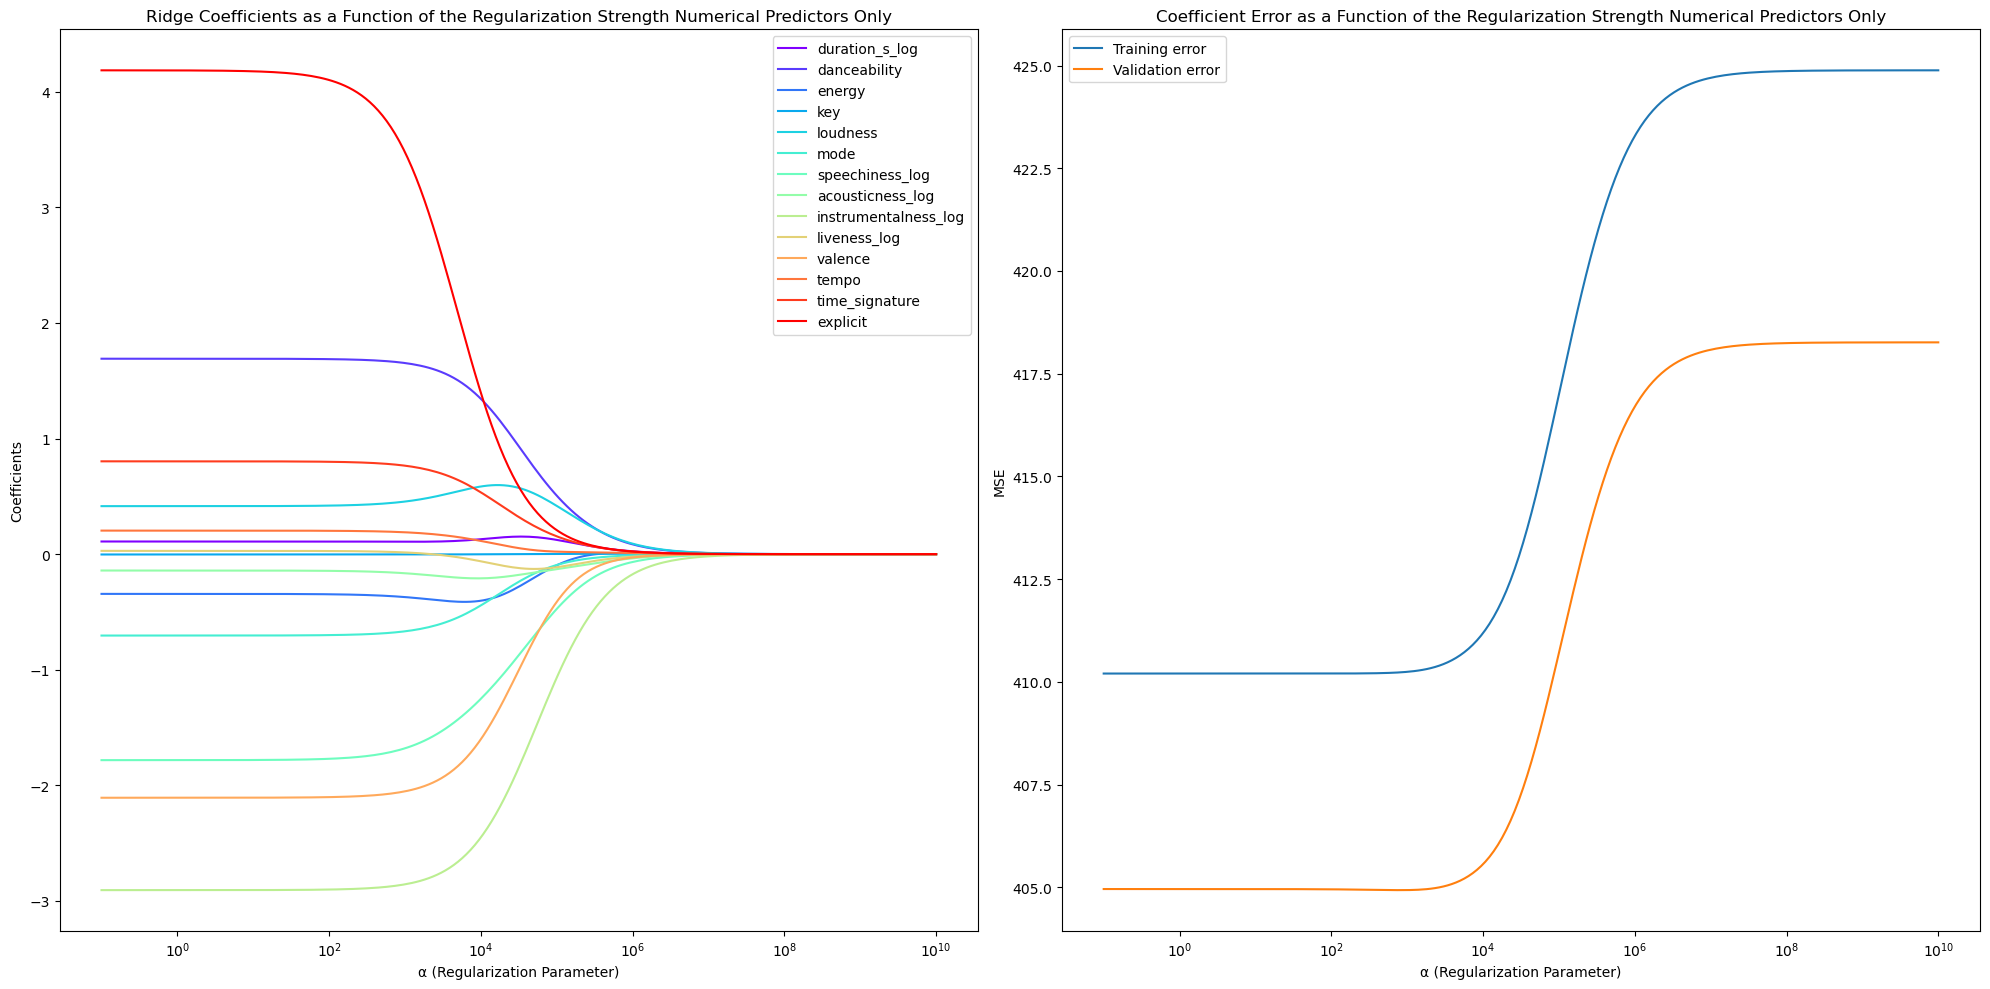

In [ ]:
alphas_closed_num, coefs_closed_num = ridge_closed.ridge_coefficients(processed_train_num, y_train)
alphas_closed_num, train_errors_closed_num, val_errros_closed_num = ridge_closed.coefficient_error(processed_train_num ,y_train, processed_test_num, y_test)
plot_ridge_and_error(alphas_closed_num, coefs_closed_num, train_errors_closed_num, val_errros_closed_num,
                     cleaned_columns_list, "Numerical Predictors Only")

The plot on the left shows how the regularisation strength alpha ($\alpha$) affects the coefficents. As $\alpha$ increases the coefficient shrinks towards zero, gradually reducing the impact of the features that were formerly significant. Even though we cannot pinpoint the exact value of shrinkage begins as it different for different coefficients but we can generally.

We can see that 'explcit' and 'duration_s_log' and 'time_signiture' have a significant positive cofficient when the alpha value is low but then tend to decrease when the alpha value increases. Furthermore, 'instrumentalnness_log' and 'valence' have a negative coefficient and start to have a steep incline when alpha valu increases.


This plot  on the right evaluates how the model performs on the training data set and the test set with different regularization strength. The general rule of thumb is that the optimal value of alpha is when the model has the lowest validation error represented by the orange line. When evaluating the mean squared error of the model against various alphas we can see that at a little past $10^4$ the mean squared error tends to increase. That means that as the value of our $\alpha$ increases above this value our mean squared error increasing which means our model will perform worse at predicting popularity.

Generally, as we increase the value of the regularization, the training and the validation errors initially decrease where they reach a minimum but then we tend to see an increase in mean squared error attributing the model becoming simplistic and not fiiting the data well enough. So finding the minimum point is imperative to balance both the bias (underfitting) and variance(overfitting).

Using the values we have created to assess to plot coefficient error as a function of the regularization strength we will be creating a data frame that would enable us to see and access the minimnum error of the training error and the test error.



In [ ]:
error_regularizations_alphas = pd.DataFrame({
    'alpha' : alphas_closed_num,
    'train error' : train_errors_closed_num,
    'val error' : val_errros_closed_num
})

In [ ]:
print("Row with minimum training error:")
print(error_regularizations_alphas.loc[error_regularizations_alphas['train error'].idxmin()])

# Print the row with the minimum validation error
print("\nRow with minimum validation error:")
print(error_regularizations_alphas.loc[error_regularizations_alphas['val error'].idxmin()])

Row with minimum training error:
alpha            0.100000
train error    410.203336
val error      404.959149
Name: 0, dtype: float64

Row with minimum validation error:
alpha          840.665289
train error    410.234117
val error      404.932509
Name: 71, dtype: float64


For the training error we obtain  $\alpha = 0.1$, in which the model has the smallest error on the training data. Where as in the testing data set the $\alpha = 840.66$ obtains the smallest error. To further soliify our understanding of how the model performs we will be use two more plots, namely, the learning curve to assess the overfitting and underfitting aspect of the model and the validation curve to see how the $R^2$ performs over different values of alpha.

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def generate_learning_curve(model, X_train, y_train, title, train_sizes, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train,
        y_train,
        train_sizes=train_sizes,
        cv=cv,
        scoring = make_scorer(rmse)
    )

    fig, ax = plt.subplots()
    ax.plot(train_sizes, np.mean(train_scores, axis=1), '-', label='Training Set')
    ax.plot(train_sizes, np.mean(test_scores, axis=1), '-', label='Cross-validation Set')
    ax.set_title(title)
    ax.set_xlabel('Training set size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')

    return fig


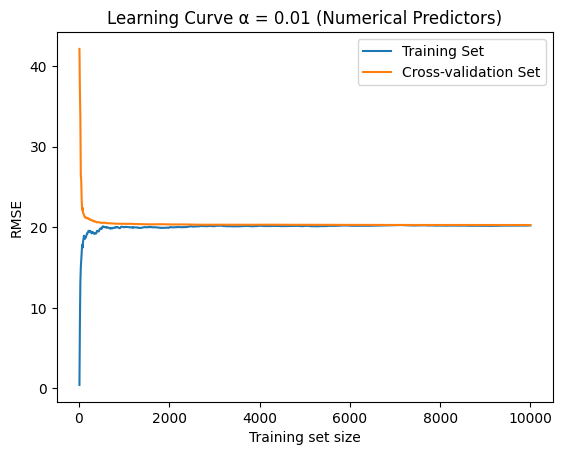

In [ ]:
train_sizes = [1, 10, 100, 1000, 10000]
train_sizes = list(range(10, 10001, 10))
learning_curve_numerical1 = generate_learning_curve(ridge_closed_pipeline, X_train_num, y_train, 'Learning Curve α = 0.01 (Numerical Predictors)', train_sizes)

The learning curve allows us to assess the performance of the model over the training set size and the validation set. We have defined the 'train_sizes' to range from 1 to 10,000 to generate the learning curve. The function subsets from the training set and evaluates the RMSE using a cross validation.

From the plot we can see that the training score increases as the training examples increase which decreases the model's performance. This is expected as the model finds it hard to fit the data. Where as the cross validaton set initially increases because but then decreases as the model performance improves. We can see that the gap between both of the curves starts to shrink.

Generally, a large gap indicates high variance (overfitting) and a small gap indicates lower variance. Since the gap shrinks the model shows that it has moderate variance. We also notice that both the curve start to stabilize around 2000 training examples with a high error rate. When the training and validation errors are high and the model doesn't benefit from increasing teining set it results in an underfitting. In this case it is typical to increase the numer of features or decrease alpha. Now let us evaluate the validation curve and see how the different values of alpha.

In [21]:
def generate_validation_curve(model, X_train, y_train, param_name, param_range, title, cv=5):
    train_scores, test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        cv=cv
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('α (Regularization Parameter)')
    ax.set_ylabel("Score R^2")
    ax.set_ylim(0.0, 1.1)
    lw = 2
    ax.semilogx(param_range, train_scores_mean, label="Training score", color="blue", lw=lw)
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    ax.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="orange", lw=lw)
    ax.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    ax.legend(loc="best")

    return fig

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


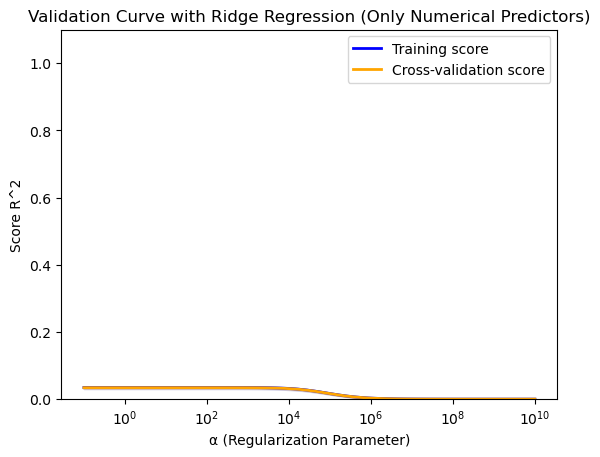

In [ ]:
alphas_val_num = np.logspace(-1, 10, 100)
validation_curve_numerical = generate_validation_curve(ridge_closed_pipeline, X_train_num, y_train, 'ridge_closed__alpha', alphas_val_num, 'Validation Curve with Ridge Regression (Only Numerical Predictors)')

The training score  is represented in orange and the cross validation set represented in blue but is not visible as because it overlays the line. Both the lines indicate that it remains consistent with the score below 0.2 indicating the model fits the training well regardless of the alpha value. But we can see a dip around $10^4$. Then when it reaches approximatley $10^6$ which suggests that the model may be too simplistic leading to a case where under-fitting may occur and it would not generalise very well to unseen data.  

Now after getting an idea of how the model performs let us conduct and tune the model as well as conduct a nested 5-fold cross validation to find the best parameter in which we will use for our modeling. So we define the range in which we are looking for our hypertuned paramter and work our way from there onwards.

In [22]:
inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
def nested_cv(X, y, inner_cv, outer_cv, model, parameter_grid):
    results = []

    for training_samples, test_samples in outer_cv.split(X, y):

        classifier = GridSearchCV(estimator = model, param_grid = parameter_grid, cv = inner_cv)
        classifier.fit(X.iloc[training_samples], y.iloc[training_samples])

        y_pred = classifier.predict(X.iloc[test_samples])
        mse = mean_squared_error(y.iloc[test_samples], y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y.iloc[test_samples], y_pred)


        results.append({
            'best_params': classifier.best_params_,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,


        })
    return pd.DataFrame(results)

In [ ]:
parameter_grid_num = {'ridge_closed__alpha': np.logspace(-6, 6, 100)}
nested_cv_closed = nested_cv(X_train_num, y_train, inner_cv, outer_cv, ridge_closed_pipeline, parameter_grid_num)

In [ ]:
nested_cv_closed

,best_params,mse,rmse,r2
0,{'ridge_closed__alpha': 43.287612810830616},402.006032,20.050088,0.034652
1,{'ridge_closed__alpha': 57.223676593502205},413.959490,20.345994,0.033216
2,{'ridge_closed__alpha': 75.64633275546291},414.522874,20.359835,0.035608
3,{'ridge_closed__alpha': 100.0},407.146742,20.177878,0.034130
4,{'ridge_closed__alpha': 43.287612810830616},414.469144,20.358515,0.032387


Results obtained from the nested cross-validation show us that the best parameter is $\alpha = 1000$ accross all of the five folds. So in the next stage we will evaluate these values in addition to the calculated mean of the best paramter and different values of alpha added on the test set which was not nested over.

In [23]:
def evaluate_nested_on_test_set(model, best_params_list, X_trains, y_trains, X_tests, y_tests):
    results = []

    # Iterate over each set of parameters in the list
    for best_params in best_params_list:
        # Set the best parameters
        model.set_params(**best_params)

        # Fit the model on the entire training set
        model.fit(X_trains, y_trains)

        # Predict on the test set
        y_pred_test = model.predict(X_tests)

        # Calculate the metrics
        mse_test = mean_squared_error(y_tests, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_tests, y_pred_test)

        # Get the alpha value dynamically
        alpha_key = [key for key in best_params.keys() if 'alpha' in key][0]
        alpha = best_params[alpha_key]

        # Append the results for this set of parameters
        results.append({
            'Alpha': alpha,
            'MSE': mse_test,
            'RMSE': rmse_test,
            'R^2': r2_test
        })

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(by='Alpha')

    return results_df

In [ ]:
# Convert the best parameters from the nested crossvalidated results into a list
best_params_closed_nested =nested_cv_closed['best_params'].tolist()


# Extract the alpha values from the best parameters, add the mean of the extracted parameter, and add different values of alpha
alpha_values = [params['ridge_closed__alpha'] for params in best_params_closed_nested]
mean_alpha = np.mean(alpha_values)
best_params_closed_nested += [{'ridge_closed__alpha': mean_alpha}]
new_values = [{'ridge_closed__alpha': 0.1}, {'ridge_closed__alpha': 10}, {'ridge_closed__alpha': 100}, {'ridge_closed__alpha': 1500},  {'ridge_closed__alpha': 10000}]
best_params_closed_nested.extend(new_values)

# Run the function of to evaluate the different alphas fitted on the training set and predicted on the test set to report their MSE, RMSE and R^2
closed_final_resulst = evaluate_nested_on_test_set(ridge_closed_pipeline, best_params_closed_nested, X_train_num, y_train, X_test_num, y_test)

In [ ]:
closed_final_resulst

,Alpha,MSE,RMSE,R^2
6,0.100000,404.959149,20.123597,0.031744
7,10.000000,404.958404,20.123578,0.031745
0,43.287613,404.955994,20.123518,0.031751
4,43.287613,404.955994,20.123518,0.031751
1,57.223677,404.955029,20.123494,0.031754
5,63.889047,404.954576,20.123483,0.031755
2,75.646333,404.953791,20.123464,0.031756
3,100.000000,404.952220,20.123425,0.031760
8,100.000000,404.952220,20.123425,0.031760
9,1500.000000,404.944973,20.123245,0.031778


In order to get an idea of how the model performs we ran it on different values of alpha ranging from 0.1 to 5000. We saw earlier the that the best parameter is $\alpha = 1000$ and when we can see indeed the model has a low MSE, RMSE and a high score of $R^2$. Overall we can see that there is some inidcation of stability but also note that the metrics, namely, MSE, RMSE increase and $R^2$ drops as the alpha values increase. For instance when $\alpha = 0.1$, which is the model doesn't show a drastic decrease when compared to the hypertuned model. Similarly, when comparing the model to $\alpha = 10,000$ we can see that the same metrics are $405.56, 20.13$ and $0.030$. The values do change but the changes are not as drastic as we expected. Let us assess the learning curve with $\alpha = 1000$.

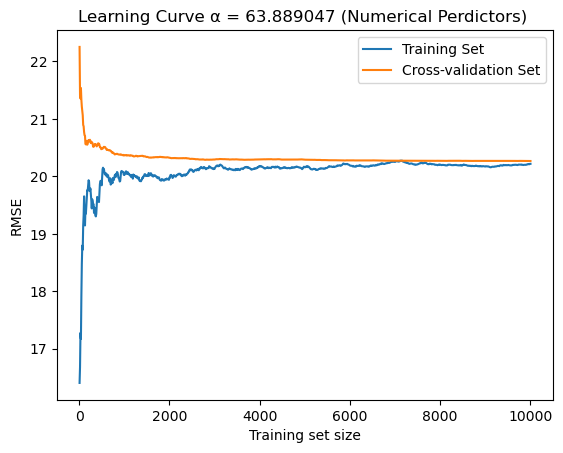

In [ ]:
ridge_closed_pipeline.set_params(ridge_closed__alpha=63.889047)

learning_curve_numerical2 = generate_learning_curve(ridge_closed_pipeline, X_train_num, y_train, "Learning Curve α = 63.889047 (Numerical Perdictors) " , train_sizes, cv = 5)

Our leaning graph that uses the alpha value from the five fold nested cross validation indictaes that the RMSE range is much smaller when compared to the learning curve with $\alpha = 0.1$. But we can also see that the training error starts off with a higher level of error because of the alpha value restricting complexity of the model to fit closely to the training data. As more training examples are added we can see that the curves begin to stabilize inidcating a reduction in overfitting.

As for the cross-validation error it follows the typical behavious starting of with a higher error and eventually decreasing as more training data increases. However, when compared to the learning curve of $\alpha = 0.1$ it has a lower error that is because the model is restricted by the regularization parameter and can generalize better to unseen data.

Overall both the curves start to stabilize with a small gap beween the training error and validation error. When we compare it to the learning curve with $\alpha = 0.1$, we can see that the model is not overly complex due to a lower value of the cross validation error  and higher value in training error that it overfits. But the problem of the model still having relative high error indicates that the model might be underfitting the data. It is is safe to conclude this might be due to only depending on the numerical features in the model and not providing enough information.

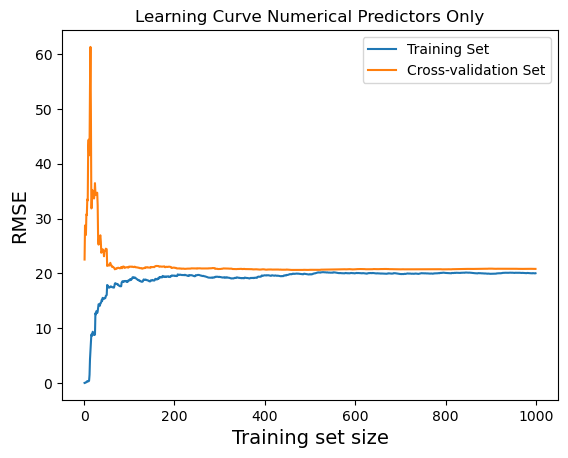

In [ ]:
# Access the 'ridge_closed' step
ridge_closed_model = ridge_closed_pipeline.named_steps['ridge_closed']

# Preprocess the training and the testing data for plotting and using the functions in the Ridge Class
X_train_num_preprocessed = ridge_closed_pipeline.named_steps['numerical_preprocessor'].transform(X_train_num)
X_test_num_preprocessed = ridge_closed_pipeline.named_steps['numerical_preprocessor'].transform(X_test_num)

# Create a smaller subset of your data, calling it 'X_train_subset_all' and 'y_train_subset_all', 'X_test_subset_all' and 'y_test_subset_all'
X_train_subset_num, X_test_subset_num = X_train_num_preprocessed[:1000], X_test_num_preprocessed[:250]
y_train_subset_num, y_test_subset_num = y_train[:1000], y_test[:250]


# Now you can use 'ridge_closed_model' to call the fucntions from the Ridge Class function
learning_curve_closed_numerical = ridge_closed_model.learning_curve(X_train_subset_num, y_train_subset_num, X_test_subset_num, y_test_subset_num, "Learning Curve Numerical Predictors Only")

In this graph we can see that the learning curve starts of with a low RMSE followed by a jump in the RMSE when the training set is small. This inidcates that the model initialy fits the data very well but as more training exmples are added the model finds it difficult to learn. However, as more examples are included in the data set we can see that the learning curve for the training set starts to stabilize. On the other hand, the validation curve represented in the blue line indicates that with a higher RMSE inidcating the model's poor capacity to generalize to unseen data. But as the test set increases we can see that the RMSE starts to decrease improving the ability to predict.

Our main concern is the gap between these two curves. A good fit is identified by a training and validation loss that decreases to a point of stability with minimal gap between the two final loss values. The model indicates that there it is underfitting in the initial stage with lower training error and high test error which is seen by the gap between both the curves. But as more training examples are added, we can see the the gap shrinks and the model starts to learn better and the underfitting reduced, but not to a point of convergence. But at a higher level of error

Now let us add more complexity to the model by adding the categorical predictors and see how the model performs.

### Numerical & Categorical - Leave-One-Out Encoding

In this stage we will include the categorical variables in our model. When conducting this we will be resorting to a leave-one-out encoding mechanism where by we will be calculating the mean of the target variable but leave out the row on which it is being calculated on. The categorical predictors that have been included are 'track_genre', 'artists', and  'album_name'.

In [24]:
categorical_features = ['artists', 'track_genre', 'album_name']
all_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist() + ["explicit"] + categorical_features

X_train_all = X_train[all_features]
X_test_all = X_test[all_features]

Our initial step is to subset all of the numerical and categorical features in the training data and the testing data.

In [25]:
genre_feature = ['track_genre']
artists_feature = ['artists']
album_feature = ['album_name']

In [26]:
leave_one_out_encoder = LeaveOneOutEncoder()
standard_scaler = StandardScaler()

preprocessor_all = ColumnTransformer(
    transformers = [
        ('genre_transformer', make_pipeline(leave_one_out_encoder, standard_scaler), genre_feature),
        ('artist_transformer', make_pipeline(leave_one_out_encoder, standard_scaler), artists_feature),
        ('album_transformer', make_pipeline(leave_one_out_encoder, standard_scaler), album_feature),
        ('numerical', numerical_preprocessor, numerical_features)
    ]
)

In [39]:
ridge_closed_all_ce = Ridge_Regression(alpha = 0.1)

In [40]:
ridge_closed_pipeline_all_ce = Pipeline([
    ('preprocessor_all', preprocessor_all),
    ('ridge_closed_all_ce', ridge_closed_all_ce)
])

In [ ]:
ridge_closed_pipeline_all_ce.fit(X_train_all, y_train)

Pipeline(steps=[('preprocessor_all',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  Pipeline(steps=[('leaveoneoutencoder',
                                                                   LeaveOneOutEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['track_genre']),
                                                 ('artist_transformer',
                                                  Pipeline(steps=[('leaveoneoutencoder',
                                                                   LeaveOneOutEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['artists']),
                                                 ('album_trans...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('ridge_closed_all_ce',
                 <__main__.Ridge_Regression object at 0x7f5fd6d6e3a0>)])

In [ ]:
y_pred_closed_all_ce = ridge_closed_pipeline_all_ce.predict(X_test)

In [ ]:
mse_closed_all_ce = mean_squared_error(y_test, y_pred_closed_all_ce)
rmse_closed_all_ce = np.sqrt(mse_closed_all_ce)
r2_closed_all_ce = r2_score(y_test, y_pred_closed_all_ce)

print(f"Mean Squared Error Closed Form All: {mse_closed_all_ce}")
print(f"Root Mean Squared Error Closed Form All : {rmse_closed_all_ce}")
print(f"R-squared Closed Form All: {r2_closed_all_ce}")

Mean Squared Error Closed Form All: 149.60492668460537
Root Mean Squared Error Closed Form All : 12.231309279247474
R-squared Closed Form All: 0.6422949945581452


When we use catgeory encoding we can see that the mean square error has dropped drastically than we when we were only using numerical predictors using $\alpha = 0.1$. The drop is from $404.59$ to $149.60$. This shows that the average squared difference between the predicted adn actual values is much better when the categorical predictors have been included using leave one out target encoding. In addition the RMSE, the square root of the MSE also drastically drops to $12.23$. Where as the $R^2$ which is the proportion of the variance in the target variable that is predicted from the predictors is approximately $0.64$ or $64\%$.Overall we can see that the model has a moderate fit to the data. Let us use different ways of assessing the model using the learning curve for checking the overfitting and uderfitting of the model, the validation curve to determine the complexity and finally the nested cross validation to tune the parameter.

In [ ]:
# Transform the training and test data
processed_train_all = preprocessor_all.transform(X_train_all)
processed_test_all= preprocessor_all.transform(X_test_all)

In [ ]:
# Get the transformed columns
transformed_columns_all = preprocessor_all.get_feature_names_out().tolist()

In [ ]:
prefixes = ['numerical__numerical__', 'album_transformer__', 'genre_transformer__', 'artist_transformer__']

cleaned_column_list_all = [col.replace(p, '') for col in transformed_columns_all for p in prefixes if col.startswith(p)]

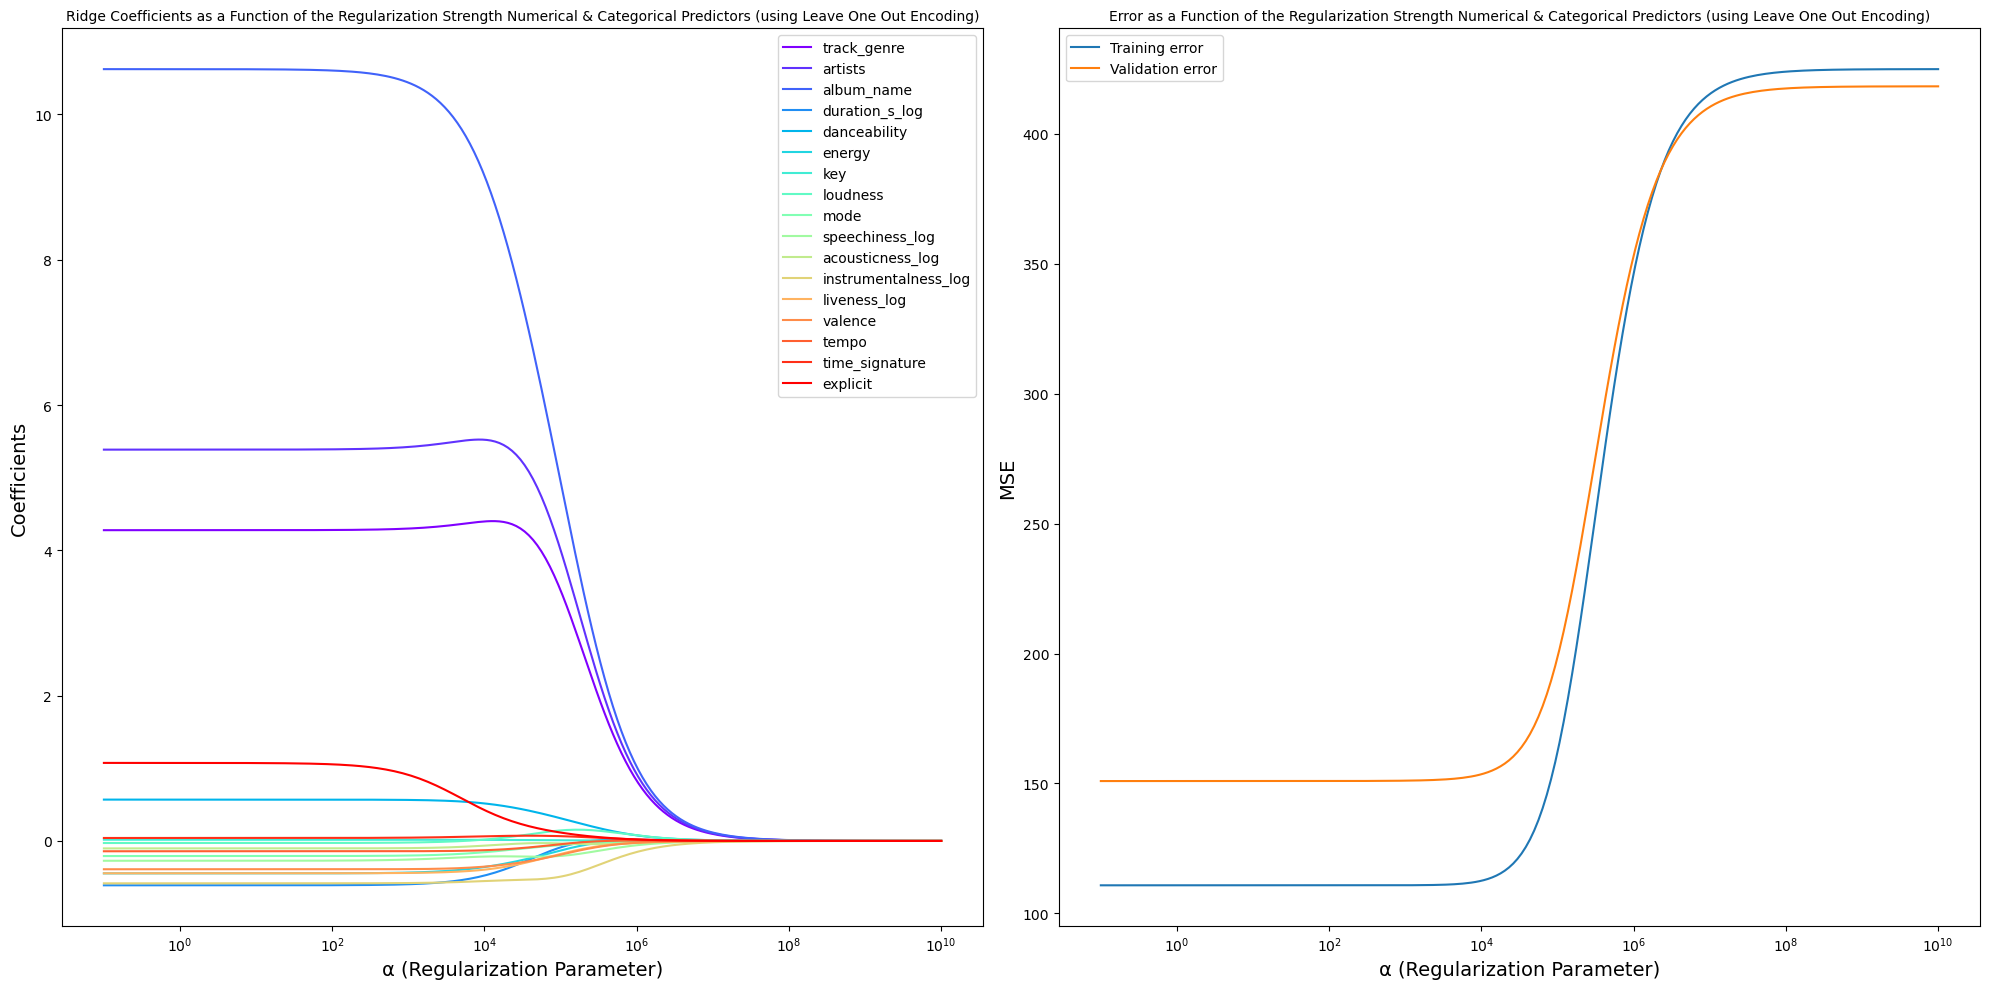

In [ ]:
alphas_closed_all_ce, coefs_closed_all_ce = ridge_closed_all_ce.ridge_coefficients(processed_train_all, y_train)
alphas_closed_all, train_errors_closed_all, val_errros_closed_all = ridge_closed_all_ce.coefficient_error(processed_train_all ,y_train, processed_test_all, y_test)
plot_ridge_and_error(alphas_closed_all_ce, coefs_closed_all_ce, train_errors_closed_all, val_errros_closed_all,
                     cleaned_column_list_all, "Numerical & Categorical Predictors (using Leave One Out Encoding)")

In the plot on the right we can see that the categorical predictors ('track_gener', 'artists' and 'album_name') inidcate that they are more significant than the numerical predictors but also indicate that they are more stable and show a decrease in coefficent with larger value of alpha when compared to the numerical predictors. We can also see a drop in the coefficients for the numerical predictors compared to our model that only contained numerical predictors are lower. Determing the exact value of alpha which the coefficent seem is a difficult tasks as the level of alpha varies for the different coefficients. Some predictors experience a rapid decrease in the case of 'explicit' where are oteher valies such as 'track_gener' experiance a slower decrease.

The plot in the left starts off with a low trianing error and a high cross validation error. We can see the gap betweem two curves when the alpha values are low which generally indicates overfitting because the model fits the training set very well where as it underpreforms on the cross validation set. Preferred outcome would of been as alpha value increases, the penalty reduces the complexity (flexibility) and the likelihood of overfitting. In our model we can see that both the trianing set and the validation error increases and the model become to simple making it difficult to generalize on unseen data.


We can see that there is a point where the training error and the validation curve start to intersect starting from a little above 350 to approximately 400 MSE. This is intersting because this might be the optimal regularization
in terms of finding the right balance between bias and vaiance. However, they are a higher error rate and this could me an that the model is too simple to capture the data due to high regularization (causing the mode to be oversimplified), or requiring more training data or a more complex model structure is required to captue the patterns of the data.

In the final stages of the plot we have reached a stage where over-regularization occurs where the model starts to underfit the training data and starts to perform better on the unseen data.




In [ ]:
error_regularizations_alphas = pd.DataFrame({
    'alpha' : alphas_closed_all_ce,
    'train error' : train_errors_closed_all,
    'val error' : val_errros_closed_all
})

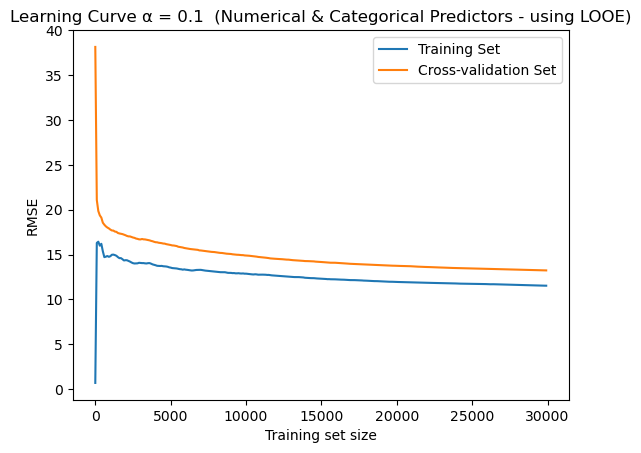

In [ ]:
train_sizes = list(range(10, 30001, 100))
learning_curve_all_ce = generate_learning_curve(ridge_closed_pipeline_all_ce, X_train_all, y_train, 'Learning Curve α = 0.1  (Numerical & Categorical Predictors - using LOOE)', train_sizes)

For the learning curve with categorical predictors we increased the number of training size to 30,000 for the plot. Our key takeaways are that the training error starts very low indicating the model to fit the data very well. But as the training examples are added the training increases and stabilizes just below 15 RMSE. Where as the cross-validation set starts with a high error, which indicates overfitting and eventually starts to decrease sharply because the model's learning capbailities are better. However the fact that the cross-validation error and the training-error plateau at a higher RMSE (below 15) inidcates a sign of underfitting. We notice that adding more data will not significantly change the performance of the model. It is important that the mode does indeed perform better with added categorical features. Let us revure the validataion curve.

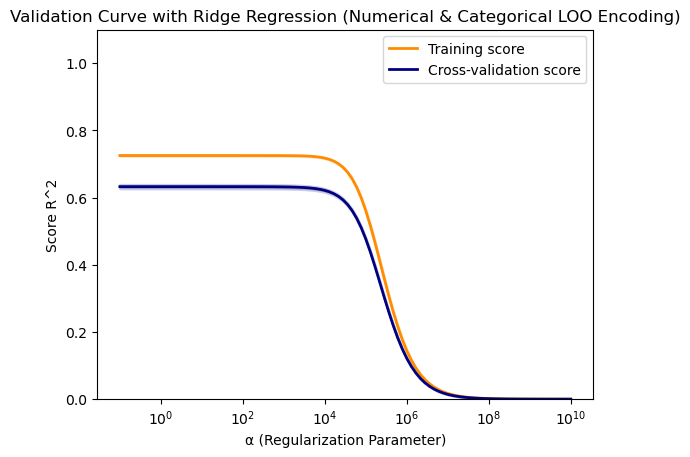

In [ ]:
alphas_val_all = np.logspace(-1, 10, 100)
validation_curve_all = generate_validation_curve(ridge_closed_pipeline_all_ce, X_train_all, y_train, 'ridge_closed_all_ce__alpha', alphas_val_all, 'Validation Curve with Ridge Regression (Numerical & Categorical LOO Encoding)')

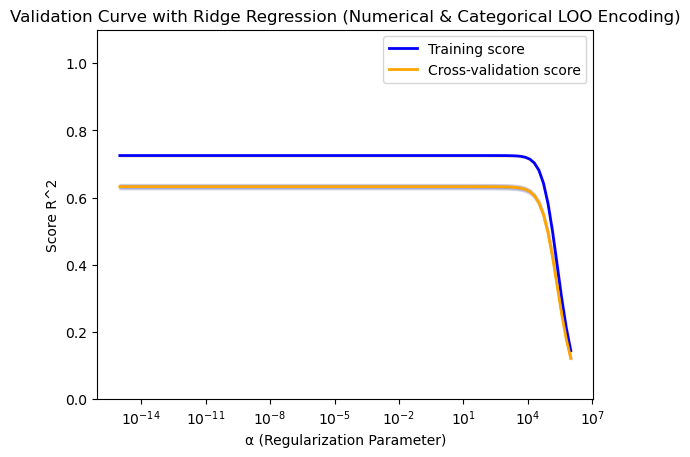

In [ ]:
alphas_val_all = np.logspace(-14, 6, 100)
validation_curve_all2 = generate_validation_curve(ridge_closed_pipeline_all_ce, X_train_all, y_train, 'ridge_closed_all_ce__alpha', alphas_val_all, 'Validation Curve with Ridge Regression (Numerical & Categorical LOO Encoding)')

This plot is similar to the previous coefficient error as a fucntion of the regularization plot the only that has changes is the y-axis, in this case it has been replaced by $R^2$. We can see that the training score and the validation score start off high and continue steadily before declining around $10^4$. As previously mention, a low value of alpha usually inidcates that the model is overfiiting which in this case is indicated by a high training score and a low cross-validation score. But as the alpha value increases the model underfits as seen by both curves converging to low score. But this is an impotant stage for us to focus our parameter search on a limited space.

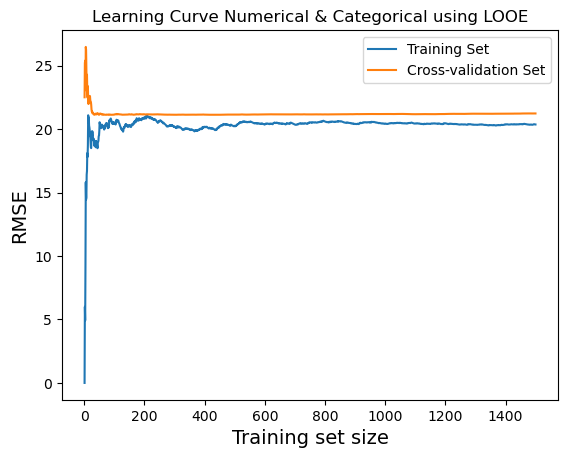

In [ ]:
# Access the 'ridge_closed' step
ridge_closed_model_all_ce = ridge_closed_pipeline_all_ce.named_steps['ridge_closed_all_ce']

# Preprocess the training and the testing data for plotting and using the functions in the Ridge Class
X_train_all_preprocessed = ridge_closed_pipeline_all_ce.named_steps['preprocessor_all'].transform(X_train_all)
X_test_all_preprocessed = ridge_closed_pipeline_all_ce.named_steps['preprocessor_all'].transform(X_test_all)

# Create a smaller subset of your data, calling it 'X_train_subset_all' and 'y_train_subset_all', 'X_test_subset_all' and 'y_test_subset_all'
X_train_subset_all, X_test_subset_all = X_train_all_preprocessed[:1500], X_test_all_preprocessed[:250]
y_train_subset_all, y_test_subset_all = y_train[:1500], y_test[:250]

# Now you can use 'ridge_closed_model' to call the fucntions from the Ridge Class function
learning_curve_closed_numerical = ridge_closed_model.learning_curve(X_train_subset_all, y_train_subset_all, X_test_subset_all, y_test_subset_all, "Learning Curve Numerical & Categorical using LOOE")

To create this plot we subsetted values from the training set(1500 examples) and the test set(250 examples). The red line which represents the training error starts low but then we can see a quick jum in error (measured in RMSE) because the model is not able to fit the data very well. But as more trining examples are added we can see that the training error starts to stabalize and starst to decrease as the model is able to learn more from the data. When assessing the validation curve we can see that it starts low but then there is jump in error as the model has not learn enough to generalize well. As more data is added the validation curve drops and continues to drop.

In the early stages we can see that the gap beteween both the curves is large. But as more training examples are added we can see the gap starting to shrink but never converge for the selcted number of trianing size.

In [ ]:
parameter_grid_all = {'ridge_closed_all_ce__alpha': np.logspace(-10, 6, 100)}
nested_cv_closed_all = nested_cv(X_train_all, y_train, inner_cv, outer_cv, ridge_closed_pipeline_all_ce, parameter_grid_all)

In [ ]:
nested_cv_closed_all

,best_params,mse,rmse,r2
0,{'ridge_closed_all_ce__alpha': 1.4508287784959...,154.405636,12.426006,0.629222
1,{'ridge_closed_all_ce__alpha': 1.4508287784959...,157.574855,12.552882,0.631991
2,{'ridge_closed_all_ce__alpha': 2.1049041445120...,162.674350,12.754386,0.621536
3,{'ridge_closed_all_ce__alpha': 2.1049041445120...,154.295621,12.421579,0.633966
4,{'ridge_closed_all_ce__alpha': 4.4306214575838...,155.386378,12.465407,0.637237


We will be taking the mean of these vlaues and assessing it on ther various meterics we have previously seen. This will give us a picture of how the the model behaves with different regularization parameter.


In [ ]:
# Convert the best parameters from the nested crossvalidated results into a list
best_params_closed_nested_all =nested_cv_closed_all['best_params'].tolist()


# Extract the alpha values from the best parameters, add the mean of the extracted parameter, and add different values of alpha
alpha_values_all = [params['ridge_closed_all_ce__alpha'] for params in best_params_closed_nested_all]
mean_alpha_all = np.mean(alpha_values_all)
best_params_closed_nested_all += [{'ridge_closed_all_ce__alpha': mean_alpha_all}]
new_values_all = [{'ridge_closed_all_ce__alpha': 0.1}, {'ridge_closed_all_ce__alpha': 10}, {'ridge_closed_all_ce__alpha': 100}, {'ridge_closed_all_ce__alpha': 1000},  {'ridge_closed_all_ce__alpha': 10000}, {'ridge_closed_all_ce__alpha': 100000}]
best_params_closed_nested_all.extend(new_values_all)

# Run the function of to evaluate the different alphas fitted on the training set and predicted on the test set to report their MSE, RMSE and R^2
closed_final_resulst_all = evaluate_nested_on_test_set(ridge_closed_pipeline_all_ce, best_params_closed_nested_all, X_train_all, y_train, X_test_all, y_test)

In [ ]:
closed_final_resulst_all

,Alpha,MSE,RMSE,R^2
0,1.450829e-10,149.604903,12.231308,0.642295
1,1.450829e-10,149.604903,12.231308,0.642295
2,2.104904e-10,149.604903,12.231308,0.642295
3,2.104904e-10,149.604903,12.231308,0.642295
5,2.308417e-10,149.604903,12.231308,0.642295
4,4.430621e-10,149.604903,12.231308,0.642295
6,1.000000e-01,149.604927,12.231309,0.642295
7,1.000000e+01,149.607247,12.231404,0.642289
8,1.000000e+02,149.628541,12.232275,0.642239
9,1.000000e+03,149.859878,12.241727,0.641685


The results from our nested corss validated and additional values of alpha ranging from 1.450829e-10 to 1.000000e+05, suggest that the model performs better on very small values. However as in our ridge regression that is conduct on numerical predictors only we can see that the changes are small compared to the value alpha and this shows that the model is not very sensitive to the alpha parameter.

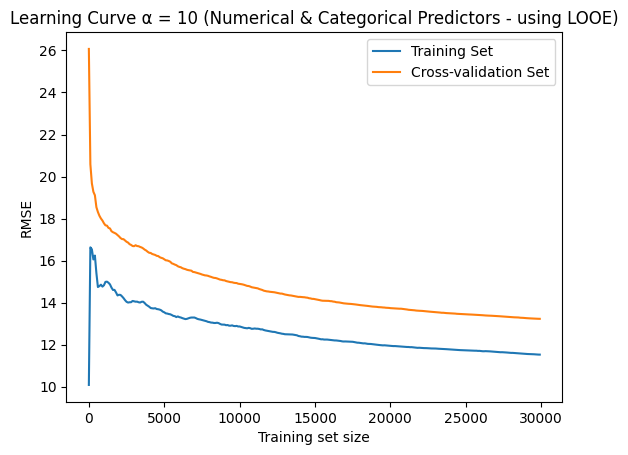

In [ ]:
ridge_closed_pipeline_all_ce.set_params(ridge_closed_all_ce__alpha= 10,000)
train_sizes = list(range(10, 30001, 100))
learning_curve_all_ce2 = generate_learning_curve(ridge_closed_pipeline_all_ce, X_train_all, y_train, 'Learning Curve α = 10,0 (Numerical & Categorical Predictors - using LOOE)', train_sizes)

The performance of the learning curve is similar to the learning curve with regularization parameter $\alpha = 0.1$. Adding more data and changing the complexity of the model in tems of alpha doesn't change the performance. So we resort to a different type of technique to handle the categorical predictors.

### Numerical & Categorical - One Hot Encoding

We have seen the performance of the preidctors with only numerical predictors, and in the previous section we have included categorical predictors using the leave one out encoding. We saw that the model started to perform moderately when the categorical features were added, now let us one hot encode and see how this stratgey pans out. It is important to note that the dimensionalty of the data will be very large and sparse.

In [27]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor_all_ohe = ColumnTransformer(
    transformers=[
        ('genre_transformer',one_hot_encoder , genre_feature),
        ('artists_transformer', one_hot_encoder, artists_feature),
        ('album_transformer', one_hot_encoder, album_feature),
        ('numerical', numerical_preprocessor, numerical_features),

    ]
)

In [28]:
ridge_closed_all_ohe = Ridge_Regression(alpha = 0.1)

In [29]:
ridge_closed_pipeline_all_ohe = Pipeline([
    ('preprocessor_all_ohe', preprocessor_all_ohe),
    ('ridge_closed_all_ohe', ridge_closed_all_ohe)
    ])

In [ ]:
ridge_closed_pipeline_all_ohe.fit(X_train_all, y_train)

Pipeline(steps=[('preprocessor_all_ohe',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['track_genre']),
                                                 ('artists_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('album_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['album_name']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('num...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('ridge_closed_all_ohe',
                 <__main__.Ridge_Regression object at 0x7fa17edd9c70>)])

In [ ]:
y_pred_closed_all_ohe = ridge_closed_pipeline_all_ohe.predict(X_test_all)

In [ ]:
mse_closed_all_ohe = mean_squared_error(y_test, y_pred_closed_all_ohe)
rmse_closed_all_ohe = np.sqrt(mse_closed_all_ohe)
r2_closed_all_ohe = r2_score(y_test, y_pred_closed_all_ohe)

print(f"Mean Squared Error Closed Form All: {mse_closed_all_ohe}")
print(f"Root Mean Squared Error Closed Form All : {rmse_closed_all_ohe}")
print(f"R-squared Closed Form All: {r2_closed_all_ohe}")

Mean Squared Error Closed Form All: 77.97727362404258
Root Mean Squared Error Closed Form All : 8.830474144916714
R-squared Closed Form All: 0.8135565338377364


Since we cannot build a plot as a fucntion of the regularization strength for the one hot encoded features as they have many columns, we will only rely on the error as a regularization stength do determin how the model behaves.

In [ ]:
processed_train_all_ohe = preprocessor_all_ohe.transform(X_train_all)
processed_test_all_ohe = preprocessor_all_ohe.transform(X_test_all)

In [ ]:
def plot_coefficient_error(alphas, train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.semilogx(alphas, train_errors, label='Training error')
    plt.semilogx(alphas, val_errors, label='Validation error')
    plt.xlabel('α (Regularization Parameter)')
    plt.ylabel('MSE')
    plt.title('Coefficient Error as a Function of the Regularization Strength')
    plt.legend()
    plt.show()



In [ ]:
alphas_closed_all_ohe, train_errors_closed_all_ohe, val_errros_closed_all_ohe = ridge_closed_all_ohe.coefficient_error(processed_train_all_ohe, y_train, processed_test_all_ohe, y_test)
plot_coefficient_error(alphas_closed_all_ohe, train_errors_closed_all_ohe, val_errros_closed_all_ohe)

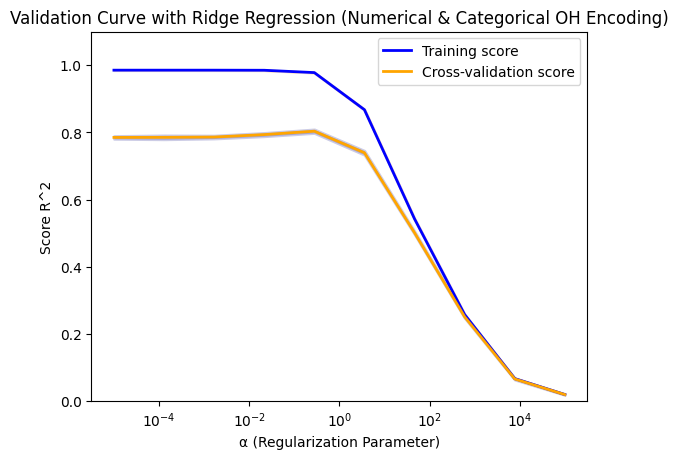

In [ ]:
alphas_val_all_ohe = np.logspace(-5, 5, 10)
validation_curve_all = generate_validation_curve(ridge_closed_pipeline_all_ohe, X_train_all, y_train, 'ridge_closed_all_ohe__alpha', alphas_val_all_ohe, 'Validation Curve with Ridge Regression (Numerical & Categorical OH Encoding)')

Validation curve for the ridge regression ran on numerical and categorical predictors treated using one hot encoding indicates that for the small values from $10^4$ to around $10^0$ the gap between the training score and the cross-validation curve is wide indicating overfitting. This means that the training score is higher than the cross-validation set score. But we can see that around $10^-1$  and $10^1$ the cross validation score peaks reducing the gap by a little. This is relatively where the gap is minimised for with a higher score. Because as we move along the x-axis and the regularization parameter increases we tend to see the gap starting to shrink but with a lower score This suggest that the model is underfitting where it performs poorly on the training and validation set. We will be using this insight to narrow down our search for for the nested cross validation step.

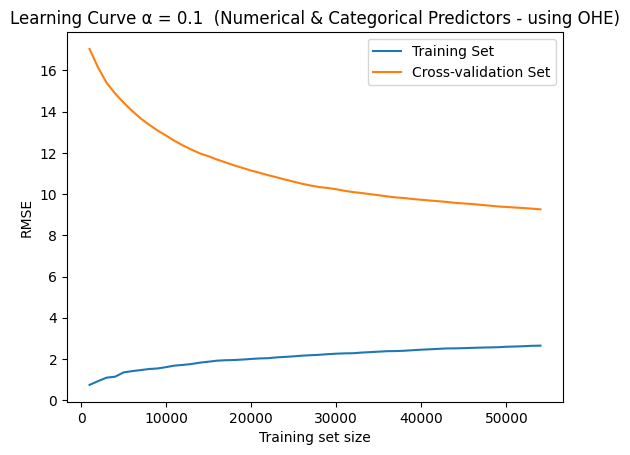

In [ ]:
train_sizes = list(range(1000, 55000, 1000))
learning_curve_all_ohe = generate_learning_curve(ridge_closed_pipeline_all_ohe, X_train_all, y_train, 'Learning Curve α = 0.1  (Numerical & Categorical Predictors - using OHE)', train_sizes)

The learning curve for the numerical and one hot encoded categorical features indicates that there is a wide gap between the training set and the cross validation suggests that the model is overfitting. This is because again the performance on the training set is better than the cross validation throughout all the trianing examples plotted. The fact that both of the curves are decreasing indicates that the model is learning and no underfitting can be detected for the training examples that are plotted. So we can conclude that the model could benefit from training data because we cannot see a state where both the curves are stabilising of converging to.

In [ ]:
parameter_grid_all_ohe = {'ridge_closed_all_ohe__alpha': np.logspace(-3, 3, 10)}
nested_cv_closed_all_ohe = nested_cv(X_train_all, y_train, inner_cv, outer_cv, ridge_closed_pipeline_all_ohe, parameter_grid_all_ohe)

In [ ]:
nested_cv_closed_all_ohe

,best_params,mse,rmse,r2
0,{'ridge_closed_all_ohe__alpha': 0.1},85.707107,9.257813,0.794189
1,{'ridge_closed_all_ohe__alpha': 0.1},81.958364,9.053086,0.808590
2,{'ridge_closed_all_ohe__alpha': 0.1},88.385661,9.401365,0.794370
3,{'ridge_closed_all_ohe__alpha': 0.1},83.262446,9.124826,0.802477
4,{'ridge_closed_all_ohe__alpha': 0.1},83.946935,9.162256,0.804019


Results from the nested cross validation indicates that the value optimal value of alpha is the one we build using our baseline. We will be using this value and different values in order to get an idea how the different ranges of alpha impact the model's performance using the metrics we are already acquainted with.

In [ ]:
# Convert the best parameters from the nested crossvalidated results into a list
best_params_closed_nested_all_ohe =nested_cv_closed_all_ohe['best_params'].tolist()


# Extract the alpha values from the best parameters, add the mean of the extracted parameter, and add different values of alpha
alpha_values_all_ohe = [params['ridge_closed_all_ohe__alpha'] for params in best_params_closed_nested_all_ohe]
mean_alpha_all_ohe = np.mean(alpha_values_all_ohe)
best_params_closed_nested_all_ohe += [{'ridge_closed_all_ohe__alpha': mean_alpha_all_ohe}]
new_values_all_ohe = [{'ridge_closed_all_ohe__alpha': 0.01},{'ridge_closed_all_ohe__alpha': 0.1}, {'ridge_closed_all_ohe__alpha': 0.5}, {'ridge_closed_all_ohe__alpha': 1}, {'ridge_closed_all_ohe__alpha': 5}, {'ridge_closed_all_ohe__alpha': 10}, {'ridge_closed_all_ohe__alpha': 100}, {'ridge_closed_all_ohe__alpha': 1000},  {'ridge_closed_all_ohe__alpha': 10000}, {'ridge_closed_all_ohe__alpha': 100000}]
best_params_closed_nested_all_ohe.extend(new_values_all_ohe)

# Run the function of to evaluate the different alphas fitted on the training set and predicted on the test set to report their MSE, RMSE and R^2
closed_final_resulst_all_ohe = evaluate_nested_on_test_set(ridge_closed_pipeline_all_ohe, best_params_closed_nested_all_ohe, X_train_all, y_train, X_test_all, y_test)

In [ ]:
closed_final_resulst_all_ohe

,Alpha,MSE,RMSE,R^2
6,0.01,82.780407,9.098374,0.802072
0,0.10,77.941656,8.828457,0.813642
1,0.10,77.941656,8.828457,0.813642
2,0.10,77.941656,8.828457,0.813642
3,0.10,77.941656,8.828457,0.813642
4,0.10,77.941656,8.828457,0.813642
5,0.10,77.941656,8.828457,0.813642
7,0.10,77.941656,8.828457,0.813642
8,0.50,77.611086,8.809715,0.814432
9,1.00,80.967452,8.998192,0.806407


Result from running different alphas on the model indicates that the regularisation parameter is actually impacted by the alpha value. We can see that performance tends to significantly deteriorate for larger values of $\alpha$. This is contrary to what we saw earlier. This means that tuning the parameter was a critical step for getting a good performance. But overall we saw that the data could indeed benefit from more data. And the overfitting could be a result of the curse of dimensionality as we have so many columns leading to a sparsity.Let us try to assess the learning curve for an alpha value that is a little higher and

 In the next stage we try to use a different type of model, specifically the kernel ridge regression in the hopes of capturing the non-linear relationship between the predictors.

### Kernel Ridge Regression

In [30]:
class Kernel_Ridge_Regression():

    def __init__(self, alpha=0.1, gamma=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.weights = None

    def get_params(self, deep=True):
        return {"alpha": self.alpha, "gamma": self.gamma}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def score(self, X, y):
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u/v

    def rbf_kernel(self, X1, X2):
      if issparse(X1):
        X1 = X1.toarray()
      if issparse(X2):
        X2 = X2.toarray()
      pairwise_sq_dists = euclidean_distances(X1, X2, squared=True)
      return np.exp(-self.gamma * pairwise_sq_dists)

    def fit(self, X, y):
      self.X_train = X
      K = self.rbf_kernel(X, self.X_train)
      y = np.array(y).reshape(-1, 1)
      I = np.eye(K.shape[0])
      XtX_plus_alphaI = K + self.alpha * I
      self.weights, _ = cg(XtX_plus_alphaI, y)

    def predict(self, X):
      K = self.rbf_kernel(X, self.X_train)
      predictions = K.dot(self.weights)
      return np.asarray(predictions).reshape(-1)

In this section we will be applying the kernel ridge regression on our spotify data set. We will be using all of the features, by treating them to leave-one-out encoding and a hot-one-encoding. In this case we will be starting with the one hot encoding then applying the leave-one-out encoding. It is important to note that we will be subsetting our training data and test data in order to successfully run this algorithm and see how it performs.

In [31]:
# Create a subsample of 20,000 data points from the training set
X_train_sub = X_train.sample(20000, random_state=42)
y_train_sub = y_train[X_train_sub.index]

# Create a subsample of 3,500 data points from the test set
X_test_sub = X_test.sample(3500, random_state=42)
y_test_sub = y_test[X_test_sub.index]

Subsetting the algorithm to 15,000 data points and the test set to 3500 will be sufficient given our memory and computation limitations. It would of been ideal if we could of included all of the data set but we will consider this as a drawback and continue our analysis.

#### KRR One-Hot-Encoding

In this section we ran the KRR with the hot-one-encoded catgeorical predictors. Unfortuntely we had to carry out collecting the various values of alternating variables due the resource limtation we encountered. This led us to manually change and enter the values to see how the model performs with different values of alpha. In addition, we also used a leave-one-out validataion because we were not able to conduct cross-validation.

In [32]:
kernel_ohe = Kernel_Ridge_Regression(alpha = 0.1, gamma = 0.1)

In [33]:
kernel_pipeline_ohe = Pipeline([
    ('preprocessor_all_ohe', preprocessor_all_ohe),
    ('kernel_ohe', kernel_ohe)
])

In [34]:
kernel_pipeline_ohe.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessor_all_ohe',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['track_genre']),
                                                 ('artists_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('album_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['album_name']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('num...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('kernel_ohe',
                 <__main__.Kernel_Ridge_Regression object at 0x7b80a973ae30>)])

In [35]:
kernel_pred_ohe = kernel_pipeline_ohe.predict(X_test_sub)

In [36]:
mse_kernel_ohe = mean_squared_error(y_test_sub, kernel_pred_ohe)
rmse_kernel_ohe = np.sqrt(mse_kernel_ohe)
r2_kernel_ohe = r2_score(y_test_sub, kernel_pred_ohe)

print(f"Mean Squared Error Closed Form All: {mse_kernel_ohe}")
print(f"Root Mean Squared Error Closed Form All : {rmse_kernel_ohe}")
print(f"R-squared Closed Form All: {r2_kernel_ohe}")

Mean Squared Error Closed Form All: 238.85532790621517
Root Mean Squared Error Closed Form All : 15.454945095541918
R-squared Closed Form All: 0.4786256441943373


In [37]:
kernel_ohe2 = Kernel_Ridge_Regression(alpha = 1, gamma = 0.1)

In [38]:
kernel_pipeline_ohe2 = Pipeline([
    ('preprocessor_all_ohe', preprocessor_all_ohe),
    ('kernel_ohe2', kernel_ohe2)
])

In [39]:
kernel_pipeline_ohe2.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessor_all_ohe',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['track_genre']),
                                                 ('artists_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('album_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['album_name']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('num...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('kernel_ohe2',
                 <__main__.Kernel_Ridge_Regression object at 0x7b80a973a830>)])

In [40]:
kernel_pred_ohe2 = kernel_pipeline_ohe2.predict(X_test_sub)

In [41]:
mse_kernel_ohe2 = mean_squared_error(y_test_sub, kernel_pred_ohe2)
rmse_kernel_ohe2 = np.sqrt(mse_kernel_ohe2)
r2_kernel_ohe2 = r2_score(y_test_sub, kernel_pred_ohe2)

print(f"Mean Squared Error Closed Form All: {mse_kernel_ohe2}")
print(f"Root Mean Squared Error Closed Form All : {rmse_kernel_ohe2}")
print(f"R-squared Closed Form All: {r2_kernel_ohe2}")

Mean Squared Error Closed Form All: 273.72853566754736
Root Mean Squared Error Closed Form All : 16.54474344520178
R-squared Closed Form All: 0.4025042681680062


In [47]:
kernel_ohe3 = Kernel_Ridge_Regression(alpha = 0.01, gamma = 0.1)

In [48]:
kernel_pipeline_ohe3 = Pipeline([
    ('preprocessor_all_ohe', preprocessor_all_ohe),
    ('kernel_ohe3', kernel_ohe3)
])

In [49]:
kernel_pipeline_ohe3.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessor_all_ohe',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['track_genre']),
                                                 ('artists_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('album_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['album_name']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('num...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('kernel_ohe3',
                 <__main__.Kernel_Ridge_Regression object at 0x7b80a55c9b10>)])

In [50]:
kernel_pred_ohe3 = kernel_pipeline_ohe3.predict(X_test_sub)

In [52]:
mse_kernel_ohe3 = mean_squared_error(y_test_sub, kernel_pred_ohe3)
rmse_kernel_ohe3 = np.sqrt(mse_kernel_ohe3)
r2_kernel_ohe3 = r2_score(y_test_sub, kernel_pred_ohe3)

print(f"Mean Squared Error Closed Form All: {mse_kernel_ohe3}")
print(f"Root Mean Squared Error Closed Form All : {rmse_kernel_ohe3}")
print(f"R-squared Closed Form All: {r2_kernel_ohe3}")

Mean Squared Error Closed Form All: 233.6636007784635
Root Mean Squared Error Closed Form All : 15.286059033592128
R-squared Closed Form All: 0.4899581667320515


In [53]:
kernel_ohe4 = Kernel_Ridge_Regression(alpha = 0.001, gamma = 0.1)

In [55]:
kernel_pipeline_ohe4 = Pipeline([
    ('preprocessor_all_ohe', preprocessor_all_ohe),
    ('kernel_ohe4', kernel_ohe4)
])

In [56]:
kernel_pipeline_ohe4.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessor_all_ohe',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['track_genre']),
                                                 ('artists_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('album_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['album_name']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('num...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('kernel_ohe4',
                 <__main__.Kernel_Ridge_Regression object at 0x7b80a56025c0>)])

In [57]:
kernel_pred_ohe4 = kernel_pipeline_ohe4.predict(X_test_sub)

In [59]:
mse_kernel_ohe4 = mean_squared_error(y_test_sub, kernel_pred_ohe4)
rmse_kernel_ohe4 = np.sqrt(mse_kernel_ohe4)
r2_kernel_ohe4 = r2_score(y_test_sub, kernel_pred_ohe4)

print(f"Mean Squared Error Closed Form All: {mse_kernel_ohe4}")
print(f"Root Mean Squared Error Closed Form All : {rmse_kernel_ohe4}")
print(f"R-squared Closed Form All: {r2_kernel_ohe4}")

Mean Squared Error Closed Form All: 234.04692066274018
Root Mean Squared Error Closed Form All : 15.298592113744983
R-squared Closed Form All: 0.489121454570409


When analyzing the result from the KRR with the categorical treated using one hot encoding we can see the best performance on a leave-one-out validation is with $\alpha = 0.01$ and $\gamma = 0.1$. We would like to emphasize this is by no means as robust as if a five fold cross-validation were to be conducted. But it is the best that we can do for now.  

### KRR Leave-One-Out Encoding

In [ ]:
kernel_ce = Kernel_Ridge_Regression()

In [ ]:
kernel_pipeline_ce = Pipeline([
    ('preprocessor_all', preprocessor_all),
    ('kernel_ce', kernel_ce)
])

In [ ]:
kernel_pipeline_ce.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessor_all',
                 ColumnTransformer(transformers=[('genre_transformer',
                                                  Pipeline(steps=[('leaveoneoutencoder',
                                                                   LeaveOneOutEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['track_genre']),
                                                 ('artist_transformer',
                                                  Pipeline(steps=[('leaveoneoutencoder',
                                                                   LeaveOneOutEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['artists']),
                                                 ('album_trans...
                                                                                    'speechiness',
                                                                                    'acousticness',
                                                                                    'instrumentalness',
                                                                                    'liveness',
                                                                                    'valence',
                                                                                    'tempo',
                                                                                    'time_signature',
                                                                                    'explicit'])]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature',
                                                   'explicit'])])),
                ('kernel_ce',
                 <__main__.Kernel_Ridge_Regression object at 0x780b98486da0>)])

In [ ]:
kernel_pred_ce = kernel_pipeline_ce.predict(X_test_sub)

In [ ]:
mse_kernel_ce = mean_squared_error(y_test_sub, kernel_pred_ce)
rmse_kernel_ce = np.sqrt(mse_kernel_ce)
r2_kernel_ce = r2_score(y_test_sub, kernel_pred_ce)

print(f"Mean Squared Error Closed Form All: {mse_kernel_ce}")
print(f"Root Mean Squared Error Closed Form All : {rmse_kernel_ce}")
print(f"R-squared Closed Form All: {r2_kernel_ce}")

Mean Squared Error Closed Form All: 182.2491819822185
Root Mean Squared Error Closed Form All : 13.499969703011132
R-squared Closed Form All: 0.5716125782994885


In [ ]:
def evaluate_cross_validate(model, model_step_name, best_params_list, X_trains, y_trains, X_tests, y_tests):
    results = []

    # Iterate over each set of parameters in the list
    for best_params in best_params_list:
        # Set the best parameters
        model.set_params(**{model_step_name+'__'+k: v for k, v in best_params.items()})
        # Perform 5-fold cross-validation on the training set
        cv_scores = cross_val_score(model, X_trains, y_trains, cv=5, scoring='neg_mean_squared_error')

        # Calculate the mean of the cross-validation scores
        mean_cv_score = np.mean(cv_scores)

        # Fit the model on the entire training set
        model.fit(X_trains, y_trains)

        # Predict on the test set
        y_pred_test = model.predict(X_tests)

        # Calculate the metrics
        mse_test = mean_squared_error(y_tests, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_tests, y_pred_test)

        # Get the alpha and gamma values dynamically
        alpha = best_params.get('alpha', None)
        gamma = best_params.get('gamma', None)

        # Append the results for this set of parameters
        results.append({
            'Alpha': alpha,
            'Gamma': gamma,
            'Mean CV Score': -mean_cv_score,  # Use negative because cross_val_score uses a negative scoring metric
            'MSE': mse_test,
            'RMSE': rmse_test,
            'R^2': r2_test
        })

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(by=['Alpha', 'Gamma'])

    return results_df

In [ ]:
best_params_list = [
    {'alpha': 0.1, 'gamma': 0.1},
    {'alpha': 1, 'gamma': 0.1},
    {'alpha': 0.5, 'gamma': 0.1},
    {'alpha': 10, 'gamma': 0.1}
]

In [ ]:
kernel_final_results_all_ce = evaluate_cross_validate(kernel_pipeline_ce, 'kernel_ce', best_params_list, X_train_sub, y_train_sub, X_test_sub, y_test_sub)

In [ ]:
kernel_final_results_all_ce

,Alpha,Gamma,Mean CV Score,MSE,RMSE,R^2
0,0.1,0.1,191.289278,182.249182,13.499970,0.571613
2,0.5,0.1,177.422287,171.359743,13.090445,0.597209
1,1.0,0.1,176.535575,170.914978,13.073446,0.598254
3,10.0,0.1,198.738074,191.735803,13.846870,0.549314


The results from the KRR with leave-one-out encoding show a better performance. Since the does not have high-dimensionality we can safely say the results are more robust and the $\alpha = 1$ and $\gamma = 0.1$ woudl be the optimal parameters given the results above.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59534c71-cd4f-44e5-bd80-e8029990d2fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>